In [1]:
import pandas as pd
import db_utils as db

df = pd.read_csv('loan_payments.csv')

Looking for columns with nulls

In [2]:
info_1 = db.DataFrameInfo()

print(info_1.get_cols_with_nulls(df))

[]


No nulls. Proceed. 

Now I am going to create a dependent variable called 'CO_or_Late' which is True in all and only the cases where the loan is Charged Off or Late.

In [3]:
print(df['loan_status'].unique())

df['CO_or_Late'] = df['loan_status'].isin(['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)'])

df['CO_or_Late'] = df['CO_or_Late'].astype('int')


['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


Now I want to isolate the categorical variables which I want to use as independent variables in this regression.

In [4]:
print(df.dtypes.value_counts())

# This shows that all the categorical variables are 'object' data types. I can now select these alone.

category_variables = df.select_dtypes(include='object').columns.to_list()

print(category_variables)

# I want to get rid of the dependent variable 'loan_status'ArithmeticError

category_variables.remove('loan_status')

float64    26
object     12
int64      11
Name: count, dtype: int64
['grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_date', 'loan_status', 'payment_plan', 'purpose', 'earliest_credit_line', 'last_payment_date', 'last_credit_pull_date', 'application_type']


Let me inspect a few of these remaining categorical variables to understand them a bit better.

In [5]:
print(df['grade'].describe(), df['grade'].value_counts())

print(df['sub_grade'].describe(), df['sub_grade'].value_counts())

count     54151
unique        7
top           B
freq      16353
Name: grade, dtype: object grade
B    16353
C    13576
A     9812
D     8139
E     4062
F     1690
G      519
Name: count, dtype: int64
count     54151
unique       35
top          B3
freq       3638
Name: sub_grade, dtype: object sub_grade
B3    3638
B4    3539
B2    3237
C1    3015
B5    3012
C2    2954
B1    2927
C3    2788
A5    2787
A4    2645
C4    2506
C5    2313
D1    1834
D2    1805
A3    1750
D3    1643
D4    1506
A2    1480
D5    1351
A1    1150
E1     987
E2     980
E3     817
E4     656
E5     622
F1     486
F2     390
F3     326
F4     284
F5     204
G1     154
G2     133
G3      87
G4      74
G5      71
Name: count, dtype: int64


From this examination it looks like grade will be a better explanatory variable than sub_grade. Lets consider some more.

In [6]:
print(df['verification_status'].describe(), df['verification_status'].value_counts())

print(df['home_ownership'].describe(), df['home_ownership'].value_counts())

print(df['payment_plan'].describe(), df['payment_plan'].value_counts())

print(df['purpose'].describe(), df['purpose'].value_counts())

count        54151
unique           3
top       Verified
freq         20759
Name: verification_status, dtype: object verification_status
Verified           20759
Not Verified       17528
Source Verified    15864
Name: count, dtype: int64
count        54151
unique           5
top       MORTGAGE
freq         26903
Name: home_ownership, dtype: object home_ownership
MORTGAGE    26903
RENT        22441
OWN          4742
OTHER          63
NONE            2
Name: count, dtype: int64
count     54151
unique        2
top           n
freq      54150
Name: payment_plan, dtype: object payment_plan
n    54150
y        1
Name: count, dtype: int64
count                  54151
unique                    14
top       debt_consolidation
freq                   29561
Name: purpose, dtype: object purpose
debt_consolidation    29561
credit_card           11126
other                  3687
home_improvement       3210
major_purchase         1675
small_business         1305
car                    1021
medical    

payment_plan isn't worth including in a regression as only one value is 'y' and the rest are 'n'. The rest look like good independent variables prima facie.

Now I am going to set up some logit regressions which is the best choice if your dependent variable is a binary one.

In [7]:
df['CO_or_Late']

0        0
1        0
2        0
3        0
4        0
        ..
54146    0
54147    0
54148    0
54149    0
54150    0
Name: CO_or_Late, Length: 54151, dtype: int64

In [8]:
info_1.logit_regression(df, 'CO_or_Late ~ C(grade)')

Optimization terminated successfully.
         Current function value: 0.343122
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             CO_or_Late   No. Observations:                54151
Model:                          Logit   Df Residuals:                    54144
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Jan 2025   Pseudo R-squ.:                 0.03453
Time:                        20:41:59   Log-Likelihood:                -18580.
converged:                       True   LL-Null:                       -19245.
Covariance Type:            nonrobust   LLR p-value:                5.342e-284
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.0375      0.048    -62.874      0.000      -3.132      -2.943
C(grade)[T.B]     0.

In [9]:
info_1.logit_regression(df, 'CO_or_Late ~ C(home_ownership)')

         Current function value: 0.354579
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             CO_or_Late   No. Observations:                54151
Model:                          Logit   Df Residuals:                    54146
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 Jan 2025   Pseudo R-squ.:                0.002295
Time:                        20:41:59   Log-Likelihood:                -19201.
converged:                      False   LL-Null:                       -19245.
Covariance Type:            nonrobust   LLR p-value:                 2.997e-18
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.1805      0.020   -108.014      0.000      -2.220      -2.141
C(home_ownership)

/Users/georgehargrave/miniconda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
info_1.logit_regression(df, 'CO_or_Late ~ C(verification_status)')

Optimization terminated successfully.
         Current function value: 0.354696
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             CO_or_Late   No. Observations:                54151
Model:                          Logit   Df Residuals:                    54148
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Jan 2025   Pseudo R-squ.:                0.001966
Time:                        20:41:59   Log-Likelihood:                -19207.
converged:                       True   LL-Null:                       -19245.
Covariance Type:            nonrobust   LLR p-value:                 3.694e-17
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -

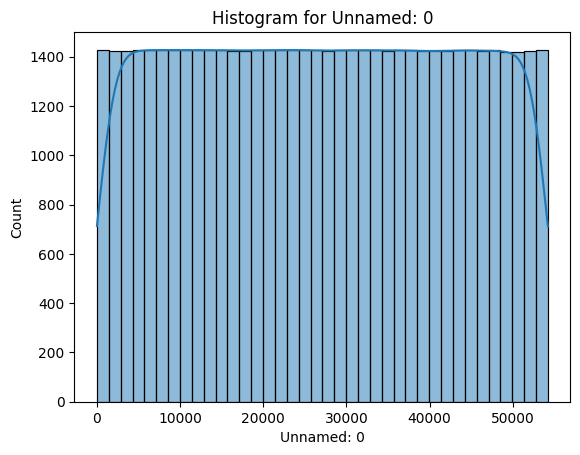

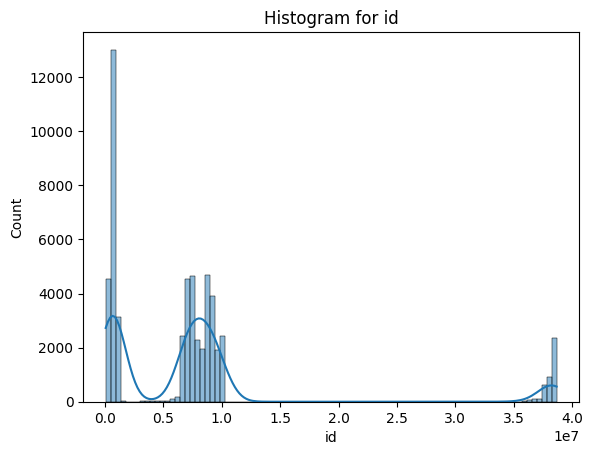

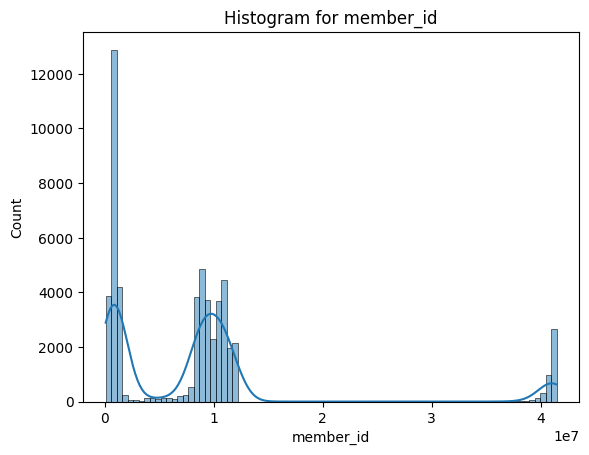

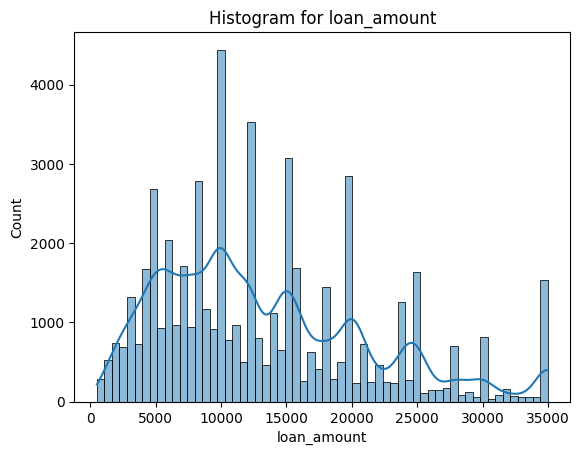

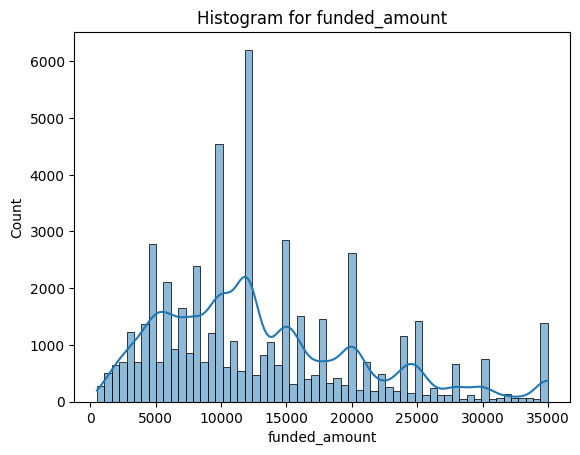

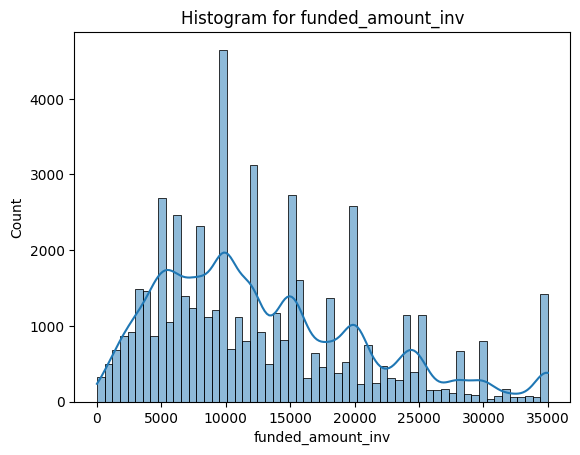

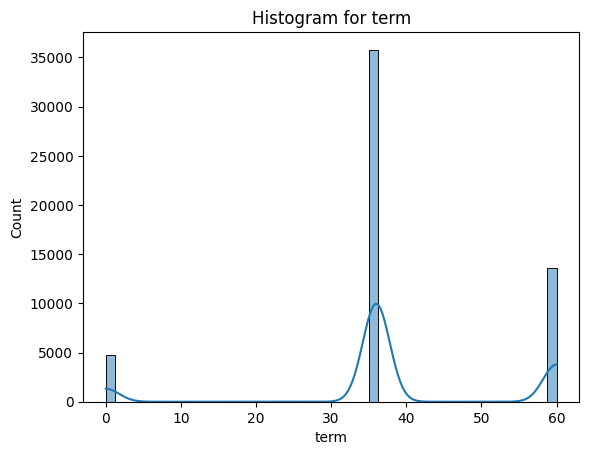

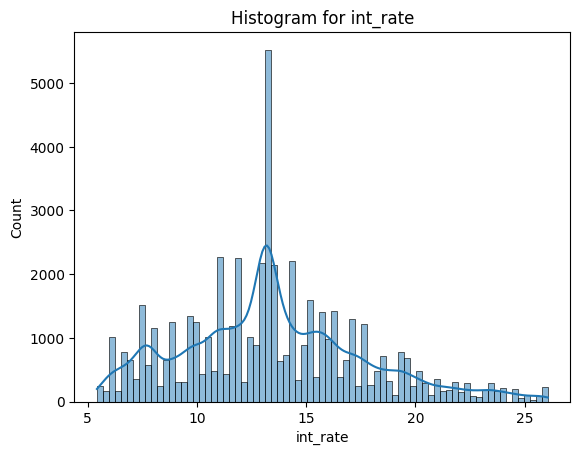

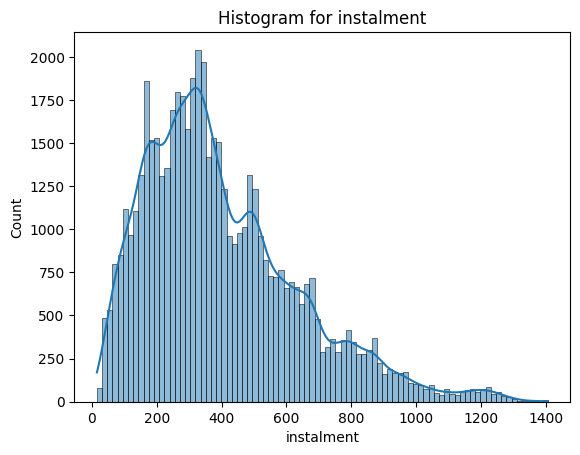

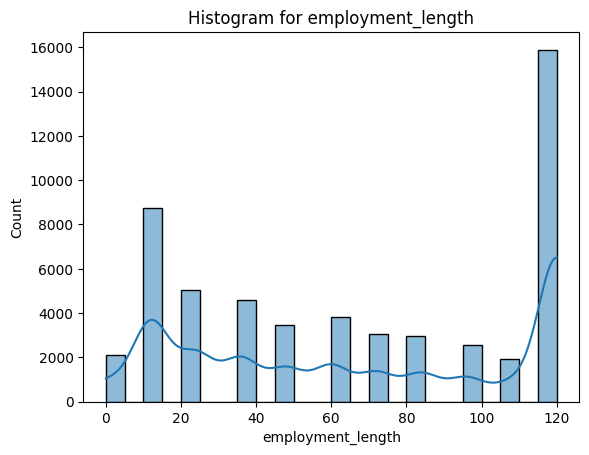

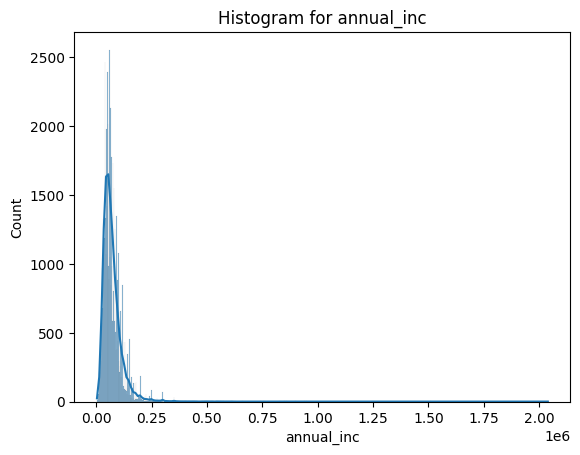

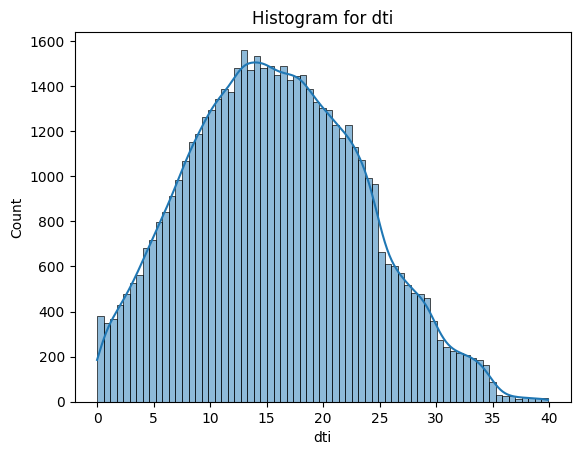

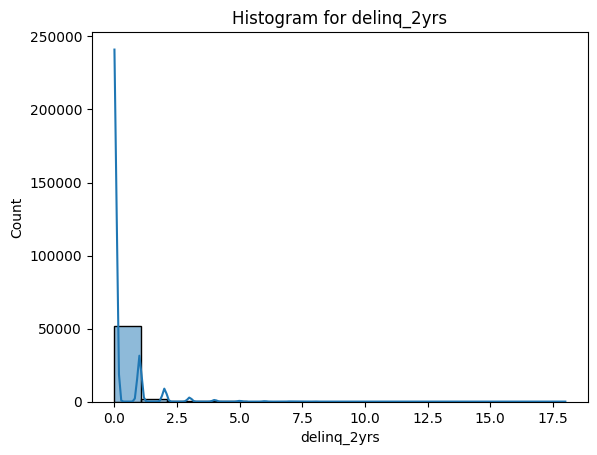

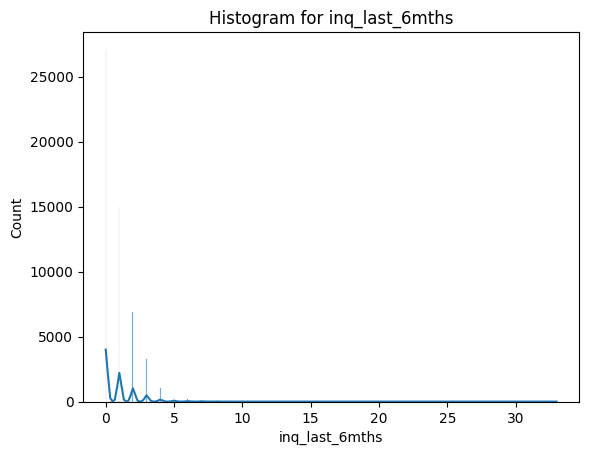

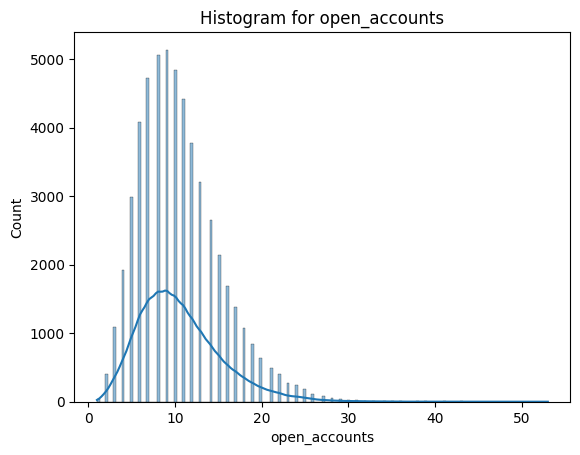

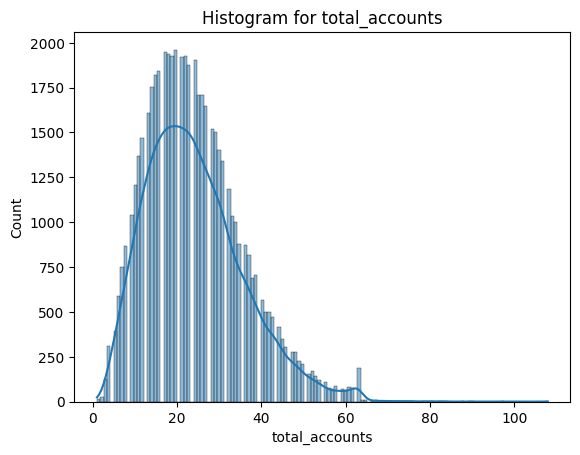

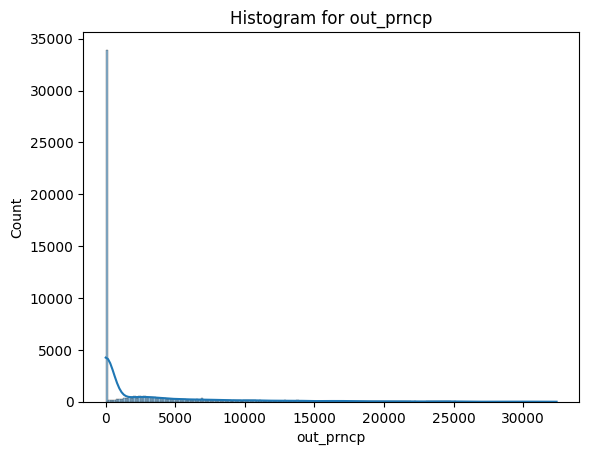

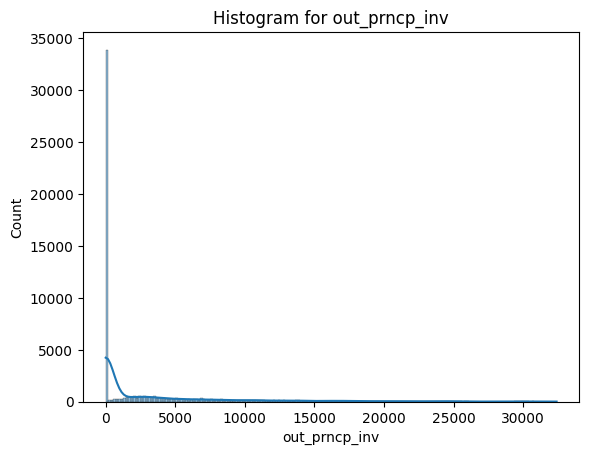

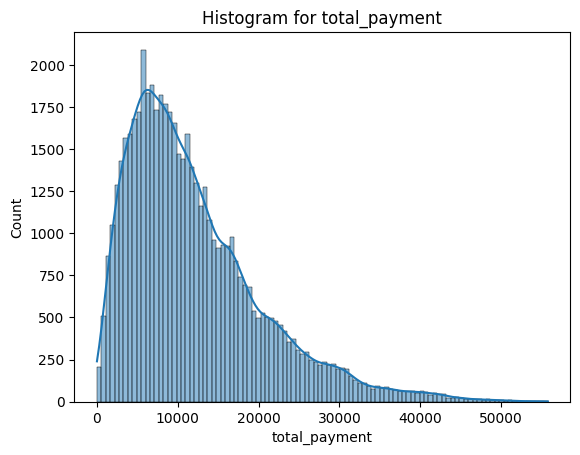

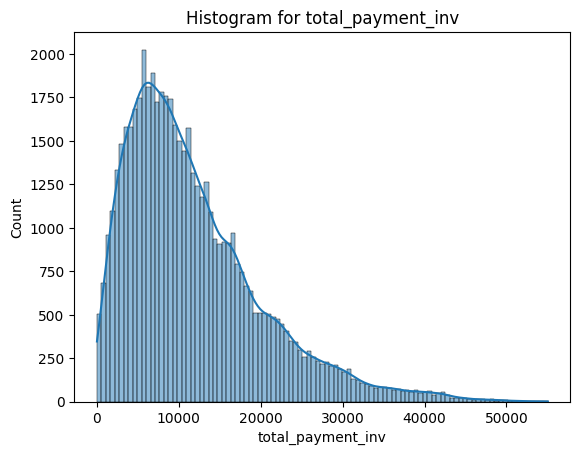

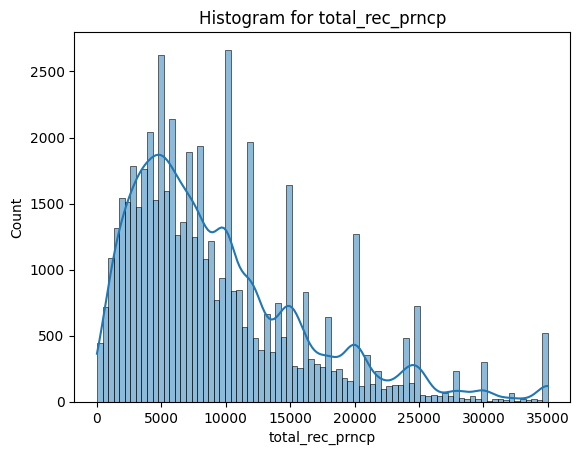

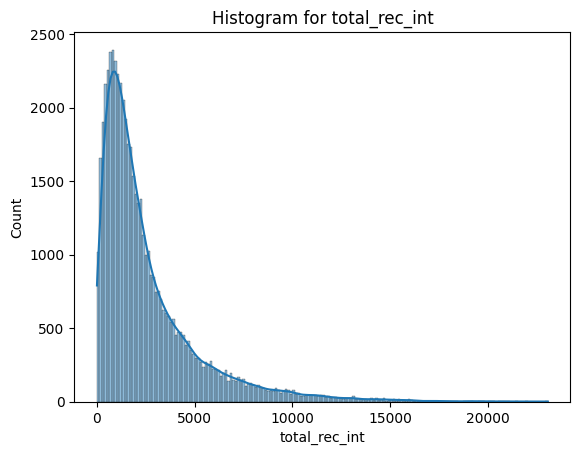

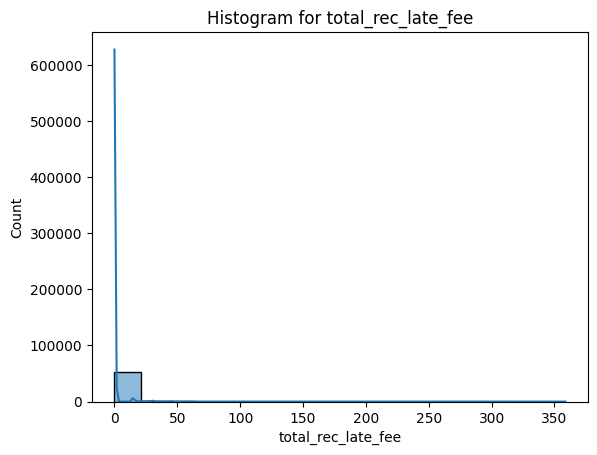

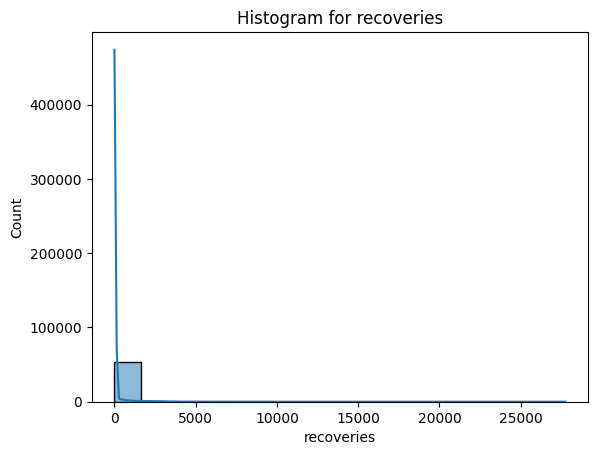

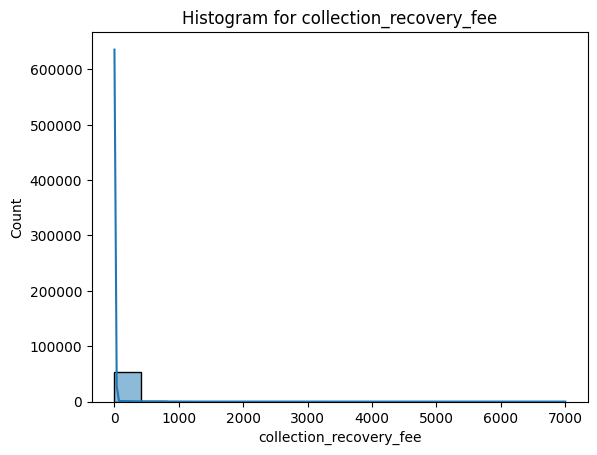

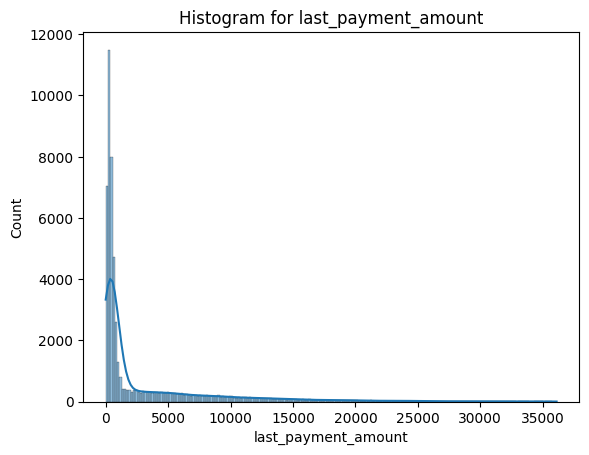

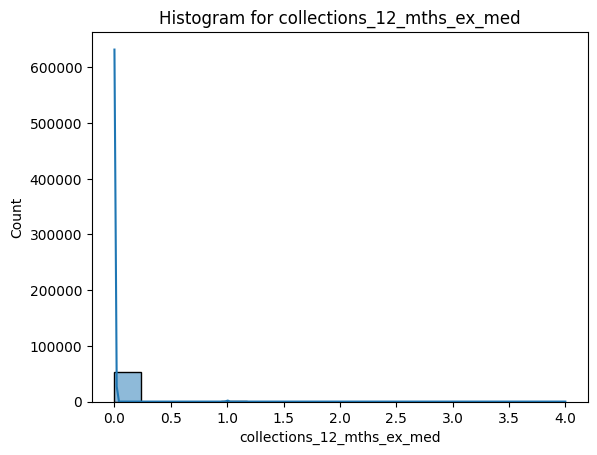

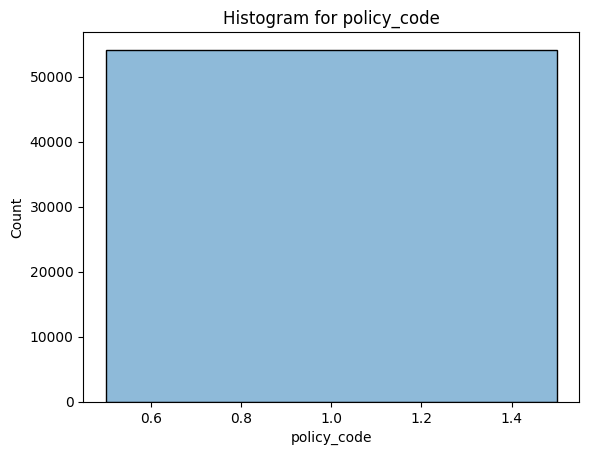

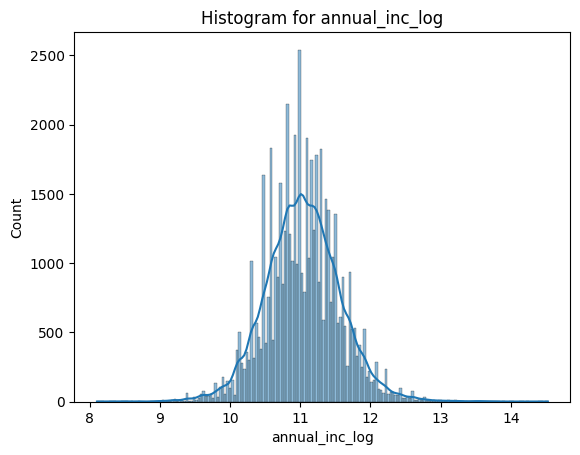

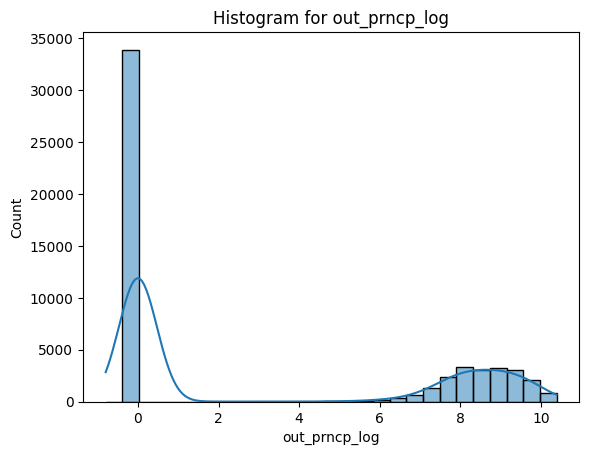

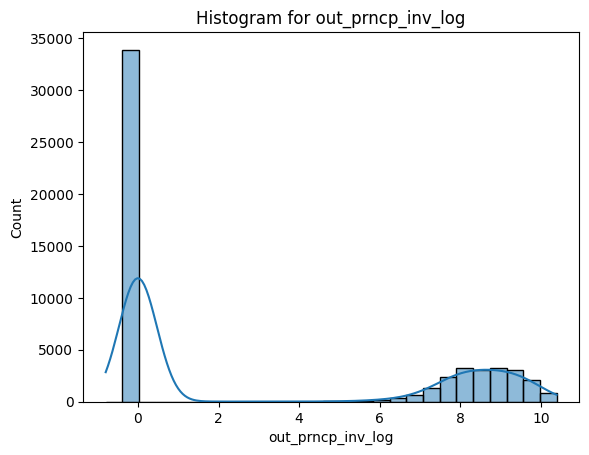

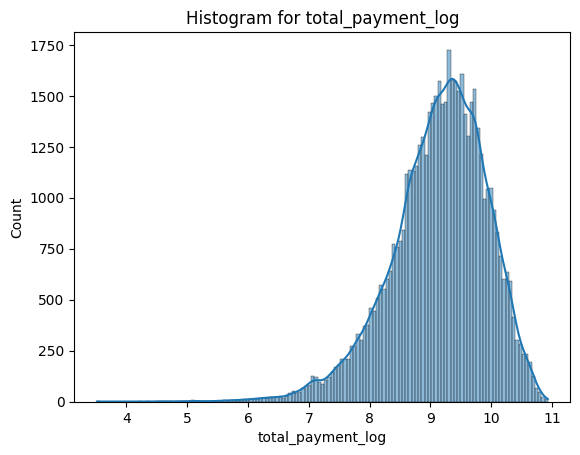

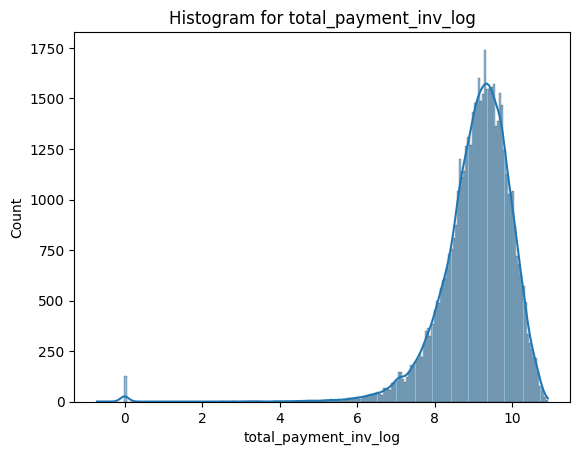

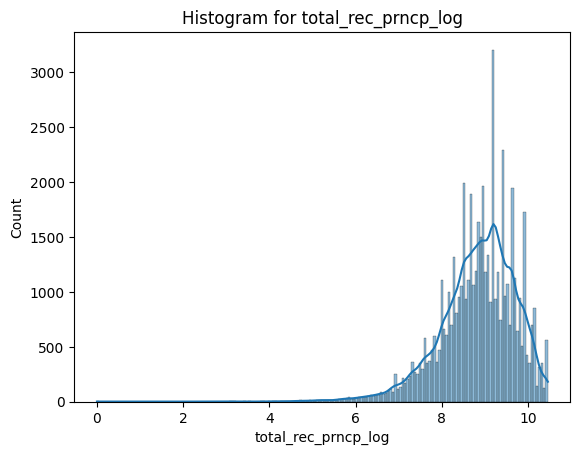

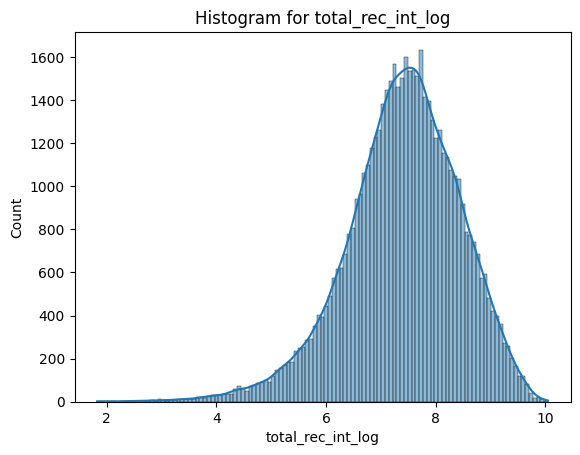

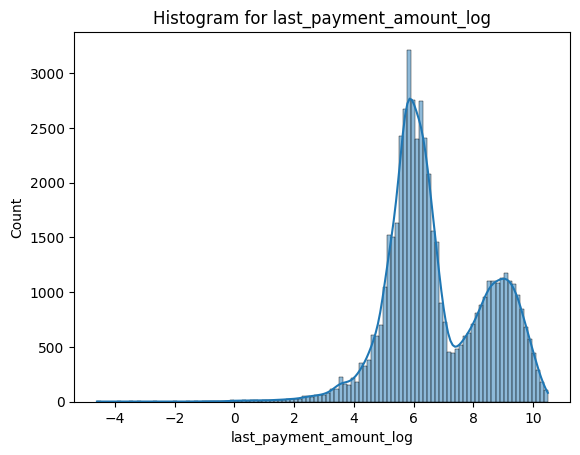

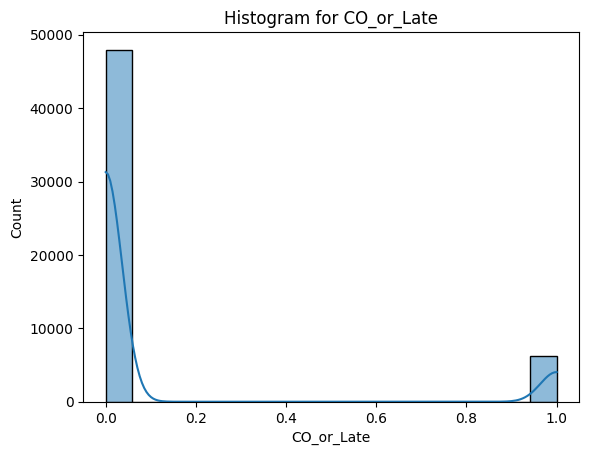

In [11]:
plotter_1 = db.Plotter()

plotter_1.kde_plot(df, df.select_dtypes(include='number').columns.to_list())

I have earmarked those columns with lots of 0 values. The new adjusted dataframe includes all these columns but with all the 0 values removed. I then concatenate these new series into a new dataframe. Where 0 values used to be they are replaced with NaN. When I call the KDE plot it ignores null values, giving me the non-0 plot for the rest of the variable.

In [12]:
cols_to_investigate = ['collection_recovery_fee', 'recoveries', 'total_rec_late_fee', 'out_prncp', 'out_prncp_inv']
new_series_ls = []
for col in cols_to_investigate:
    new_series_ls.append(pd.Series(df[df[col] > 0][col], name = col))

new_df = pd.concat(new_series_ls, axis=1)

Plotting all these non-0 values of the earmarked variables.

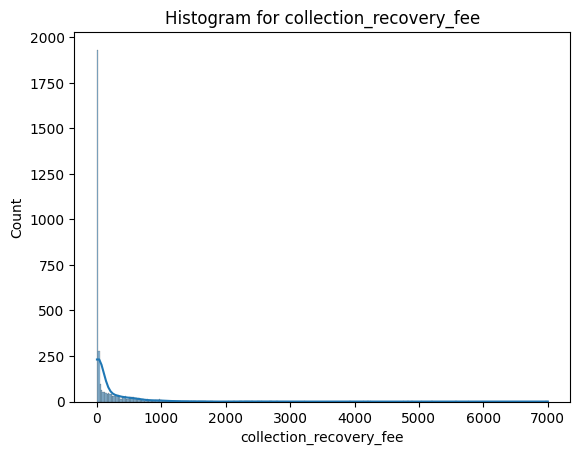

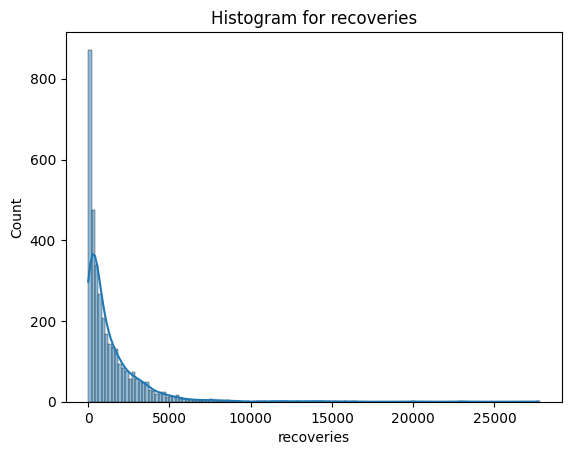

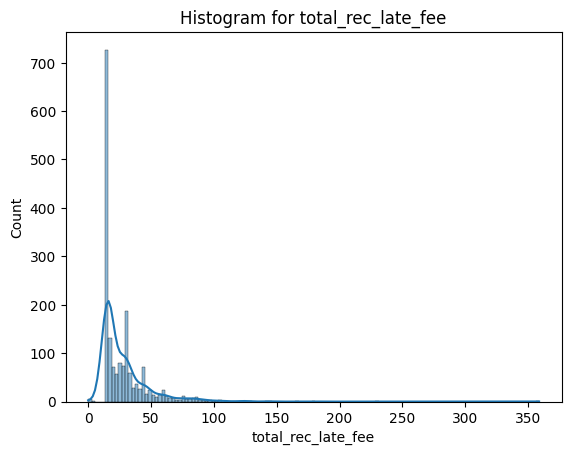

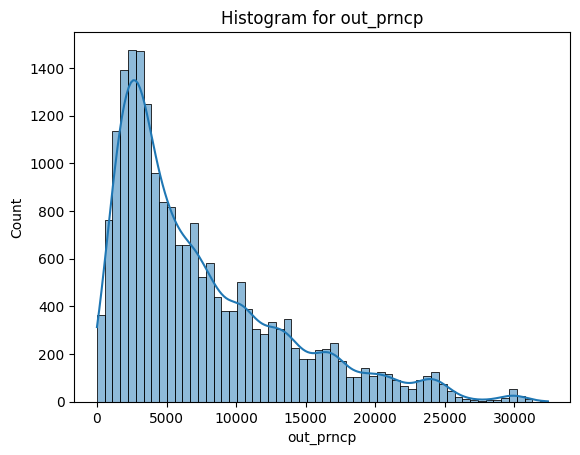

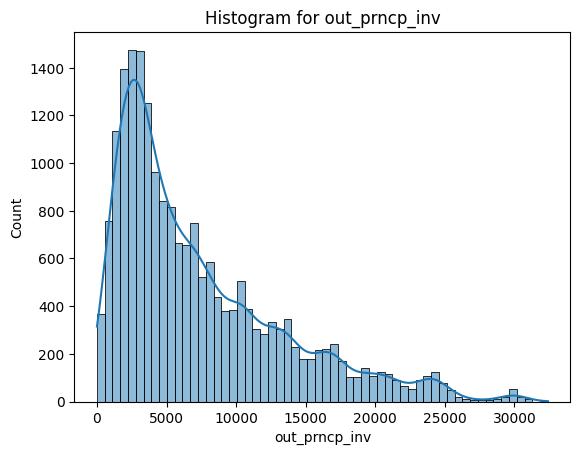

In [13]:
plotter_1.kde_plot(new_df, cols=cols_to_investigate)

Getting their skews

In [14]:
for col in cols_to_investigate:
    print(info_1.col_skewness(new_df, col))

7.322799257123017
4.261722782595498
4.530415046686879
1.269555622673881
1.26956558993692


Performing a Yeo-Johnson transformation on them. 

In [15]:
df_transformer_1 = db.DataFrameTransformer()

for col in cols_to_investigate:
    new_df[col] = df_transformer_1.yeo_johnson_transform(new_df, col)

Skew of collection_recovery_fee after Yeo-Johnson transformation: 0.14037262041589899
Skew of recoveries after Yeo-Johnson transformation: -0.051630608332976426
Skew of total_rec_late_fee after Yeo-Johnson transformation: -0.09699046992130296
Skew of out_prncp after Yeo-Johnson transformation: -0.02315138681854382
Skew of out_prncp_inv after Yeo-Johnson transformation: -0.023259012572889967


Replacing the old non-0 values in the original dataframe with the transformed ones.

In [16]:
for col in new_df.columns.to_list():
    df[df[col]>0][col] = new_df[col]

/var/folders/w9/1rp208pd7qg9pzxvfsqvs_km0000gn/T/ipykernel_18872/2672221201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df[col]>0][col] = new_df[col]


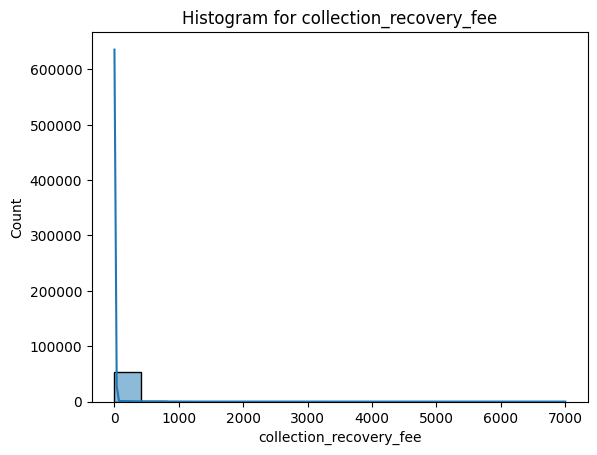

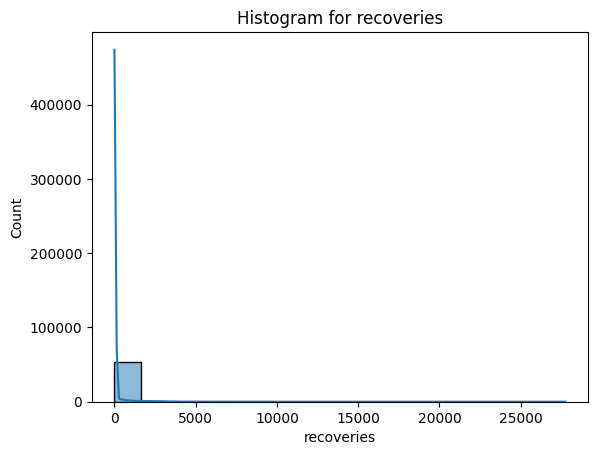

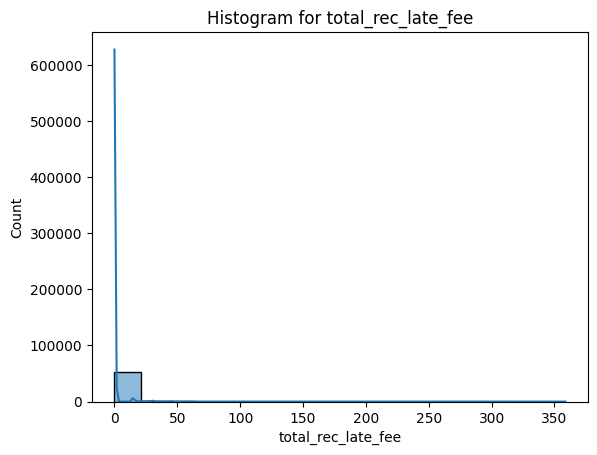

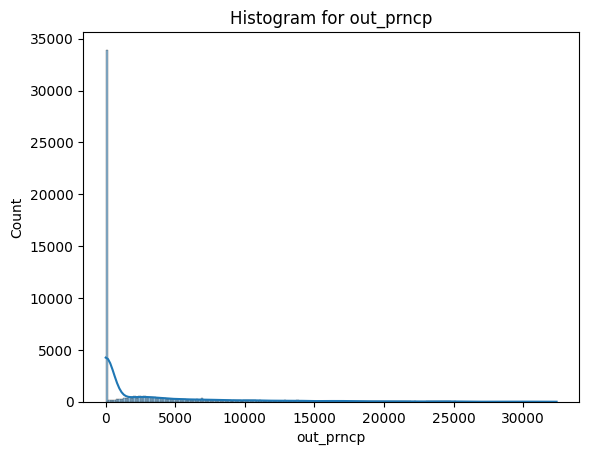

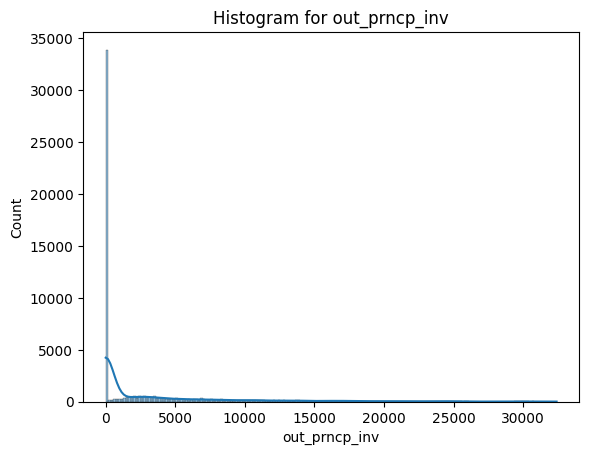

In [17]:
plotter_1.kde_plot(df, cols=cols_to_investigate)

Saving df as updated version of 'loan_payments.csv' locally

In [18]:
db.save_df_as_csv(df, 'loan_payments.csv')

File saved.
